### File Reading:文本读取

In [1]:
# 文本路径
train_pos_path = 'data/train.positive.txt'
train_neg_path = 'data/train.negative.txt'
stop_path = 'data/stopwords.txt'
test_comb_path = 'data/test.combined.txt'

In [2]:
import re
import pandas as pd

def process_file(data_path, label=None):
    
     # 去除换行符替换成空格
    with open(data_path,'r') as file:
        data_file = file.read().replace('\n',' ')
    
    # 正则表达式提取文本 
    # 去除字符串两端多余的空格
    if label != None:
        pattern = re.compile('<review id="\d+">(.*?)</review>')
        data_file = [[label, i.strip()] for i in pattern.findall(data_file)] 
    else:
        pattern = re.compile('<review id="\d+"  label="(\d)">(.*?)</review>')
        data_file = [[int(i[0]), i[1].strip()] for i in pattern.findall(data_file)]
        
    df = pd.DataFrame(data_file, columns=['Label', 'Comments'])
    
    return df

df_train = pd.concat([process_file(train_neg_path, 0), process_file(train_pos_path, 1)])        
df_test = process_file(test_comb_path)

In [3]:
# TO DO
train_comments = df_train['Comments'].tolist()
train_label = df_train['Label'].tolist()
test_comments = df_test['Comments'].tolist()
test_label = df_test['Label'].tolist()

### Explorary Analysis:可视化分析

In [4]:
print(len(train_comments), len(test_comments))

8063 2500


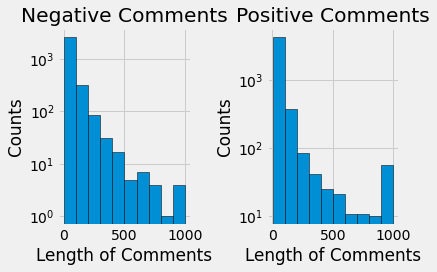

In [5]:
# 关于老师的假想验证

from matplotlib import pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')

filt = (df_train['Label'] == 0)
neg_x = df_train.loc[filt,:]['Comments'].map(len)
pos_x = df_train.loc[~filt,:]['Comments'].map(len)

ax1 = plt.subplot(121)
plt.hist(neg_x, edgecolor='black', log=True)
plt.title('Negative Comments')
plt.xlabel('Length of Comments')
plt.ylabel('Counts')

ax2 = plt.subplot(122)
plt.hist(pos_x, edgecolor='black', log=True)
plt.title('Positive Comments')
plt.xlabel('Length of Comments')
plt.ylabel('Counts')

plt.tight_layout()
# 通过图像分析，我的答案是评论的长度并不能算得上是可以判断正负面情感的靠谱的特征

### 文本预处理

In [6]:
import jieba

with open(stop_path,'r') as file:
    stop_file = [i.strip() for i in file.readlines()]
    
# 去掉特殊符合 停留词
def clean_data(text, stop_file):
    
    text = re.sub('[!！]+', " ", text)
    text = re.sub('[?？]+', " ", text)
    text = re.sub('[~~ ]+', " ", text)
    text = re.sub('[～～ ]+', " ", text)
    text = re.sub("[a-zA-Z#$%&\'()*+,-./:;：<=>@，。★、…【】《》“”‘’[\\]^_`{|}~]+"," ", text)
    text = re.sub('[\d]+', " NUM ", text)
    text = re.sub("\s+", " ", text)
    text = text.replace('＂', '').replace('＂','')
    token = jieba.lcut(text)
    
    return ' '.join([i.replace(' ','') for i in token if i not in stop_file and i != ' ' and i != 'NUM'])    

train_comments_cleaned = [clean_data(i, stop_file) for i in train_comments]
test_comments_cleaned = [clean_data(i, stop_file) for i in test_comments]    

print(train_comments_cleaned[0], test_comments_cleaned[0])
print(train_comments_cleaned[1], test_comments_cleaned[1])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.487 seconds.
Prefix dict has been built successfully.


看过 此人 百家讲坛 演讲 简直 垃圾 终于 找到 同道中人 初中 已经 喜欢 上 同学 都 鄙夷 眼光 看 人为 样子 古怪 说 丑 当场 气晕 现在 同道中人 好开心
中 曲目 包装 上 完全 不 怀疑 盗版 卓越 说法 看 完 已 深夜 两点 却 坐在 电脑前 情难 自禁 这是 最好 结局 惟有 就让 前世 今生 纠结 停留 此刻 再 相逢 时 愿 人生 不再 人 唏嘘 身心 会 只 居 一处 痛心 人 爱


### 文本转成向量

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(train_comments_cleaned)
y_train = train_label
X_test = vectorizer.transform(test_comments_cleaned)
y_test = test_label

print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))

(8063, 23096) (2500, 23096) (8063,) (2500,)


### 训练模型

In [8]:
from sklearn.naive_bayes import MultinomialNB

bayes_modle=MultinomialNB()

#训练数据
bayes_modle.fit(X_train,y_train)

#对模型评分
model_score=bayes_modle.score(X_test,y_test)
print(model_score)

0.6584
